# Generating Digits using Conditional GAN
In this project, I want to implement the most basic version of a Conditional  
GAN to generate MNIST-like images.

-- Gholamreza Dar, Dec 2024


loosely based on https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

SEED = 69
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device: {device}")
print(f"torch version: {torch.__version__}")

device: cuda
torch version: 2.5.1+cu121


In [2]:
# Huggingface login and helper functions
HF_REPO_ID = "Gholamreza/conditional_gan_mnist"

from google.colab import userdata
import huggingface_hub
from huggingface_hub import login, hf_hub_download, HfApi

def save_to_hub(file_name, file_in_repo_name=None, repo_id=HF_REPO_ID):
    if file_in_repo_name == None:
        file_in_repo_name = file_name

    api = HfApi()
    api.upload_file(
        path_or_fileobj=file_name,
        path_in_repo=file_in_repo_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {file_name} to {repo_id}/{file_in_repo_name}")

def load_from_hub(file_in_repo_name, repo_id=HF_REPO_ID):
    return hf_hub_download(repo_id=repo_id, filename=file_in_repo_name)

login(token=userdata.get('HF_TOKEN'))

## Model

### get_noise function

In [3]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn((n_samples, z_dim), device=device)

In [4]:
def get_random_labels(n_samples, device='cpu'):
    return torch.randint(0, 10, (n_samples,), device=device).type(torch.long)

In [5]:
get_noise(2, 3, device=device)

tensor([[-1.6594,  1.9279,  0.8757],
        [ 0.3105,  1.1376, -0.7348]], device='cuda:0')

In [6]:
get_random_labels(2, device=device)

tensor([6, 8], device='cuda:0')

### Generator


In [7]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        # input is of shape (batch_size, z_dim + 10)
        self.gen = nn.Sequential(
            get_generator_block(z_dim + 10, hidden_dim), # 128
            get_generator_block(hidden_dim, hidden_dim*2), # 256
            get_generator_block(hidden_dim*2, hidden_dim*4), # 512
            get_generator_block(hidden_dim*4, hidden_dim*8), # 1024
            nn.Linear(hidden_dim*8, im_dim), # 784
            nn.Sigmoid(), # output between 0 and 1
        )

    def forward(self, noise, classes):
        '''
        noise (batch_size, z_dim) noise vector for each image in a batch
        classes:long (batch_size) condition class for each image in a batch
        '''
        # classes = classes.type(torch.long)
        # one-hot encode condition_class e.g. 3 -> [0,0,0,1,0,0,0,0,0,0]
        one_hot_vec = F.one_hot(classes, num_classes=10).type(torch.float32) # (batch_size, 10)
        conditioned_noise = torch.concat((noise, one_hot_vec), dim=1) # (batch_size, z_dim + 10)
        return self.gen(conditioned_noise)


In [9]:
def generator_loss(gen, disc, criterion, num_images, z_dim, device):
    # generate fake images
    noise = get_noise(num_images, z_dim, device=device)
    fake_labels = get_random_labels(num_images, device=device)
    fake_images = gen(noise, fake_labels)

    # concat the labels with the generated images before passing them to the discriminator
    fake_labels_ohe = F.one_hot(fake_labels, num_classes=10).type(torch.float32)
    fake_images_conditioned = torch.concat((fake_images, fake_labels_ohe), dim=1)
    y_pred = disc(fake_images_conditioned)

    # calculate loss
    y_gt = torch.ones_like(y_pred)
    return criterion(y_pred, y_gt)

In [10]:
# from torchsummary import summary
generator = Generator(z_dim=10, im_dim=784, hidden_dim=128).to(device)
generator(get_noise(2, 10, device=device), get_random_labels(2, device=device)).shape
# summary(generator, [(2,10), (2,10)])

torch.Size([2, 784])

## Discriminator


In [11]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [12]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim + 10, hidden_dim*4), # 512
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2), # 256
            get_discriminator_block(hidden_dim * 2, hidden_dim), # 128
            nn.Linear(hidden_dim, 1),
            # nn.Sigmoid(),
            # using a sigmoid followed by BCE is less numerically stable than BCEWithLogitsLoss alone
            # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss:~:text=This%20loss%20combines%20a%20Sigmoid%20layer%20and%20the%20BCELoss%20in%20one%20single%20class.%20This%20version%20is%20more%20numerically%20stable%20than%20using%20a%20plain%20Sigmoid%20followed%20by%20a%20BCELoss%20as%2C%20by%20combining%20the%20operations%20into%20one%20layer%2C%20we%20take%20advantage%20of%20the%20log%2Dsum%2Dexp%20trick%20for%20numerical%20stability.
        )

    def forward(self, image_batch):
        '''image_batch (batch_size, 784+10)'''
        return self.disc(image_batch)

In [13]:
def discriminator_loss(gen, disc, criterion, real, real_labels, num_images, z_dim, device, alpha=0.5):
    ''' alpha is the weight of the discriminator loss '''
    noise = get_noise(num_images, z_dim, device=device)
    fake_labels = get_random_labels(num_images, device=device)
    fake_images = gen(noise, fake_labels)

    # add conditioning to fake and real images
    real_labels_ohe = F.one_hot(real_labels, num_classes=10).type(torch.float32)
    real_conditioned = torch.concat((real, real_labels_ohe), dim=1)
    fake_labels_ohe = F.one_hot(fake_labels, num_classes=10).type(torch.float32)
    fake_images_conditioned = torch.concat((fake_images, fake_labels_ohe), dim=1)

    # HOW CONDITIONING WORKS
    # after prev lines discriminator is conditioned on seeing a one hot vector
    # corresponding to the class of the image at the end of the image vector (when flattened)
    # So if there is a mismatch between the ohe vector and the contents of the image,
    # disc will say false!
    # So gen will have to generate images that correspond to the label given to it `gen(noise, label)`
    # otherwise disc will definitely catch that it's fake because it doesn't resemble the real data that it
    # has seen before

    # prediction using discriminator
    y_pred_real = disc(real_conditioned)
    y_pred_fake = disc(fake_images_conditioned)

    # calculate losses
    y_gt_real = torch.ones_like(y_pred_real)
    y_gt_fake = torch.zeros_like(y_pred_fake)
    average_loss = alpha * criterion(y_pred_real, y_gt_real) + (1 - alpha) * criterion(y_pred_fake, y_gt_fake)
    return average_loss

In [14]:
discriminator = Discriminator(im_dim=784, hidden_dim=128).to(device)
discriminator(torch.randn((2, 784+10)).to(device))
# summary(discriminator, (784,))

tensor([[-0.0039],
        [ 0.0349]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Data


In [15]:
from torchvision.datasets import MNIST
from torchvision import transforms

BATCH_SIZE = 64

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [16]:
batch = next(iter(dataloader))
images, labels = batch
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [17]:
def display_image_grid(images, num_rows=5, title=""):
    if(images.shape[-1]!=28):
        images = images.view(-1, 1, 28, 28)
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title(title)
    grid = make_grid(images.detach().cpu()[:25], nrow=num_rows).permute(1, 2, 0).numpy()
    # print(grid.shape)
    plt.imshow(grid)
    plt.show()

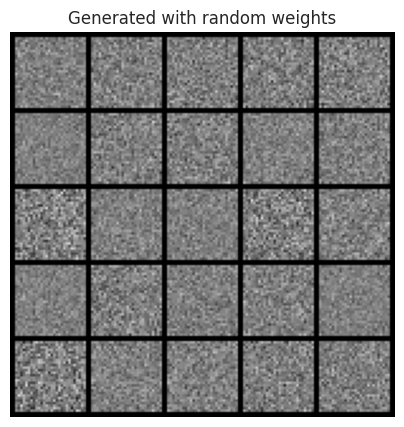

In [18]:
display_image_grid(generator(get_noise(25, 10, device=device), get_random_labels(25, device=device)), title="Generated with random weights")

## Training

In [19]:
len(dataloader)

938

In [20]:
938*BATCH_SIZE

60032

In [21]:
def train(gen, disc, criterion, real, num_images, z_dim, device, alpha=0.5):
    EPOCHS = 100
    iter_count = 0

    opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0001)
    opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0001)

    gen.train()
    disc.train()

    for epoch in range(EPOCHS):
        for real, real_labels in dataloader:
            real = real.view(-1, 784).to(device)
            real_labels = real_labels.to(device)

            # train discriminator
            disc_loss = discriminator_loss(gen, disc, criterion, real, real_labels, num_images, z_dim, device, alpha)
            opt_disc.zero_grad()
            disc_loss.backward(retain_graph=True)
            opt_disc.step()

            # train generator
            gen_loss = generator_loss(gen, disc, criterion, num_images, z_dim, device)
            opt_gen.zero_grad()
            gen_loss.backward(retain_graph=True)
            opt_gen.step()

            gen_losses.append(gen_loss.item())
            disc_losses.append(disc_loss.item())

            iter_count += 1

            if(iter_count % 1000 == 0):
                print(f"{iter_count} gen_loss: {gen_loss.item():.4f}, disc_loss: {disc_loss.item():.4f}")
            if(iter_count % 1000 == 0):
                # Display a grid of generations
                gen.eval()
                label = torch.randint(0, 10, (1,), device=device).item() # a sample label to generate
                fake_eval_batch = gen(get_noise(25, 10, device=device), torch.tensor([label] * 25).to(device))
                display_image_grid(fake_eval_batch, title=f"Generated @ step: {iter_count} | Class: {label}")
                gen.train()
            if(iter_count % 5000 == 0):
                save_model_to_hub(gen, "generator.pt")
                save_model_to_hub(disc, "discriminator.pt")

    return gen_losses, disc_losses

In [22]:
def save_model_to_hub(model, file_name):
    torch.save(model.state_dict(), file_name)
    save_to_hub(file_name, file_in_repo_name=file_name)

def load_model_from_hub(model, file_name):
    file_path = load_from_hub(file_name)
    model.load_state_dict(torch.load(file_path))

In [23]:
gen_losses = []
disc_losses = []
generator = Generator(z_dim=10, im_dim=784, hidden_dim=128).to(device)
discriminator = Discriminator(im_dim=784, hidden_dim=128).to(device)

In [24]:
# load_model_from_hub(generator, "generator.pt")
# load_model_from_hub(discriminator, "discriminator.pt")

1000 gen_loss: 3.3667, disc_loss: 0.0604


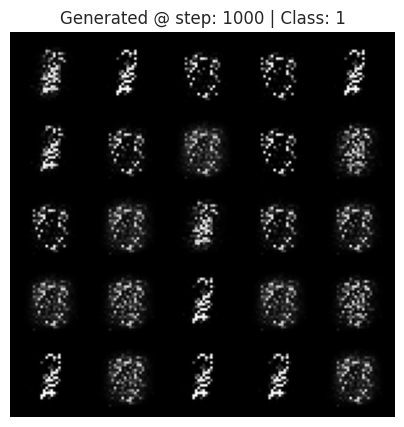

2000 gen_loss: 4.4756, disc_loss: 0.1412


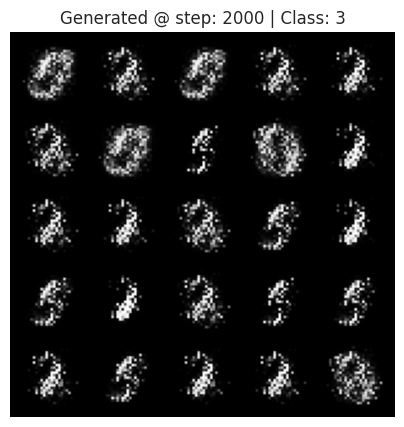

3000 gen_loss: 4.2721, disc_loss: 0.1331


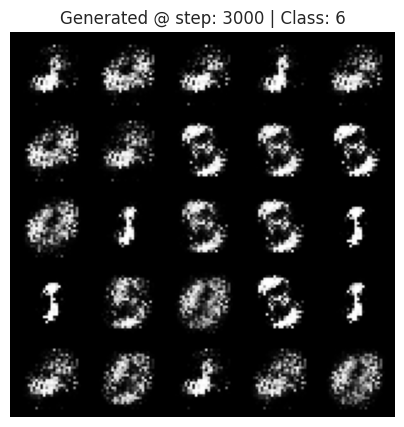

4000 gen_loss: 4.7036, disc_loss: 0.1735


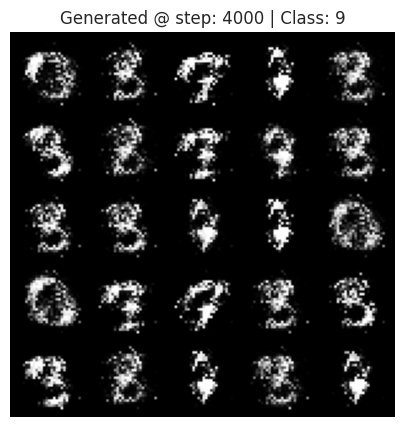

5000 gen_loss: 4.7101, disc_loss: 0.0702


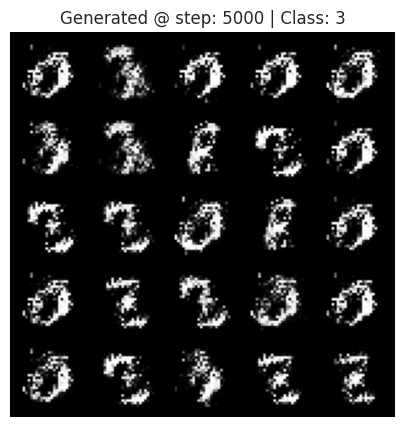

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
6000 gen_loss: 4.7700, disc_loss: 0.1063


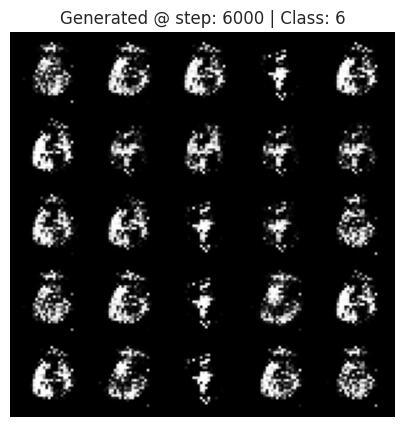

7000 gen_loss: 4.0287, disc_loss: 0.1937


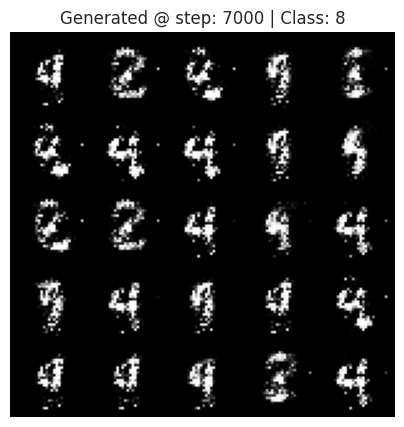

8000 gen_loss: 3.6615, disc_loss: 0.1350


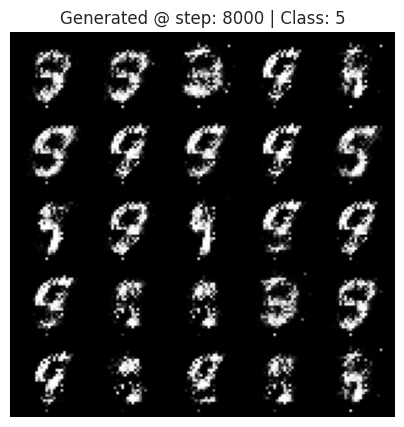

9000 gen_loss: 3.5954, disc_loss: 0.1225


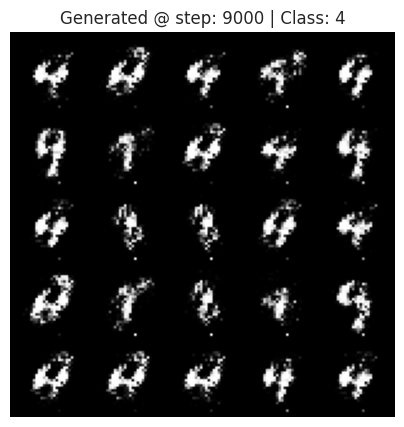

10000 gen_loss: 3.3036, disc_loss: 0.1138


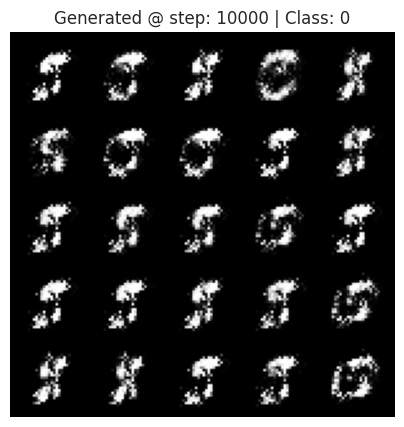

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
11000 gen_loss: 3.4185, disc_loss: 0.1760


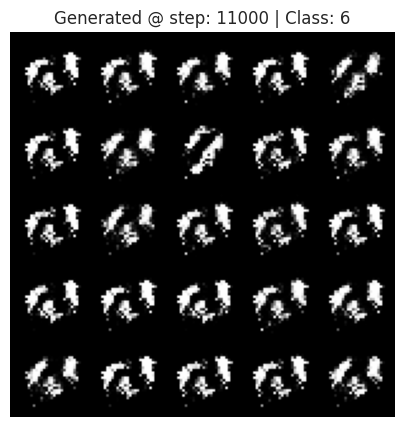

12000 gen_loss: 3.6212, disc_loss: 0.0999


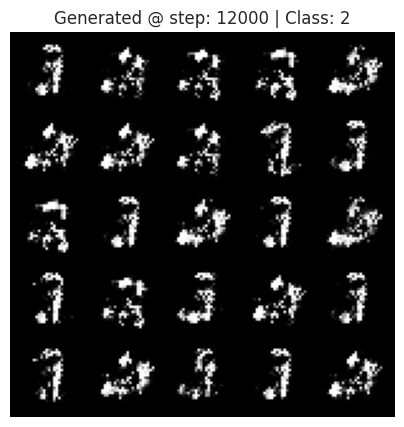

13000 gen_loss: 3.3274, disc_loss: 0.1915


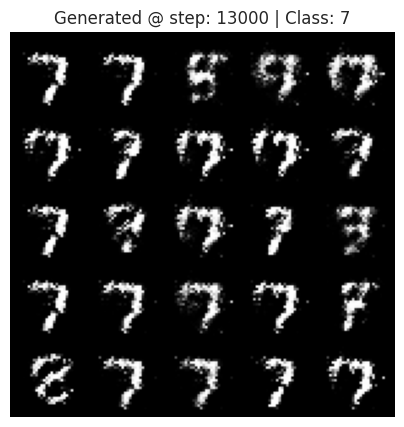

14000 gen_loss: 3.2941, disc_loss: 0.3479


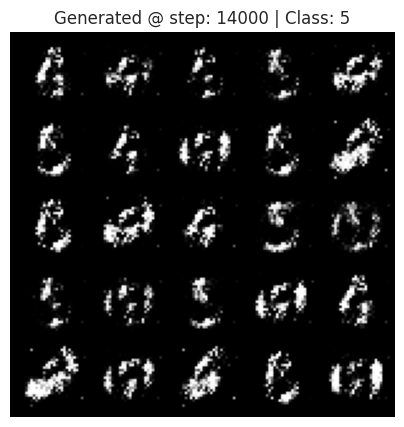

15000 gen_loss: 3.8962, disc_loss: 0.2188


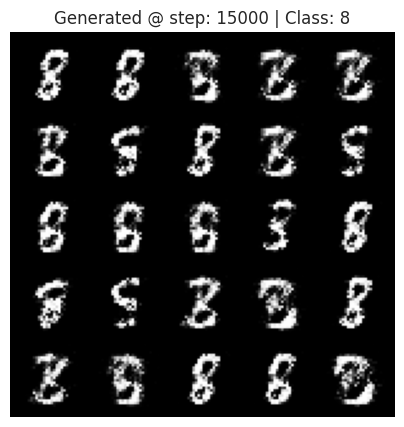

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
16000 gen_loss: 3.6280, disc_loss: 0.1821


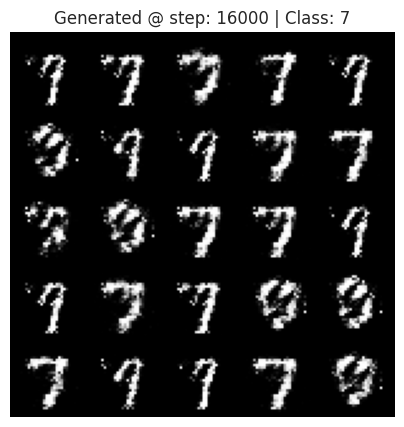

17000 gen_loss: 2.6349, disc_loss: 0.2431


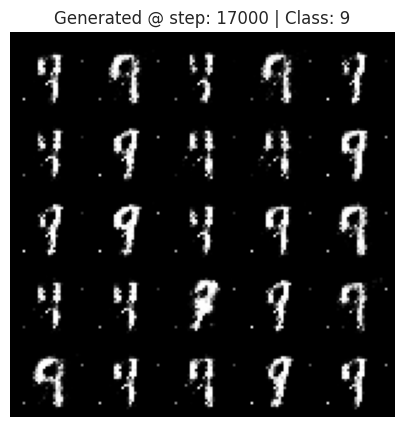

18000 gen_loss: 3.0249, disc_loss: 0.1981


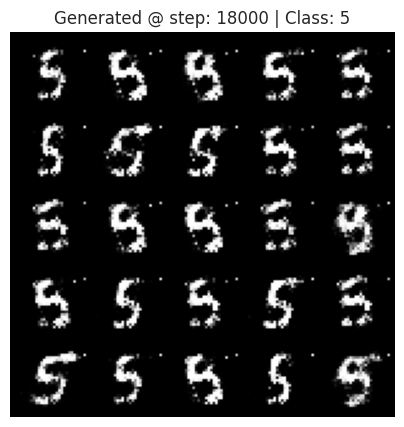

19000 gen_loss: 2.3728, disc_loss: 0.3165


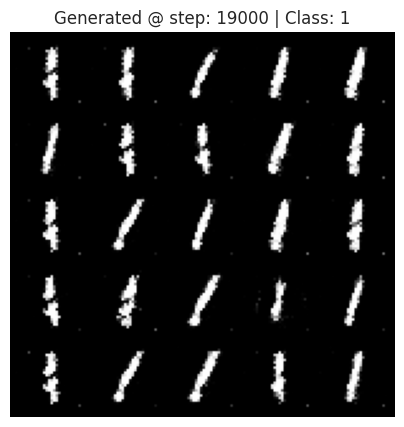

20000 gen_loss: 2.4497, disc_loss: 0.2615


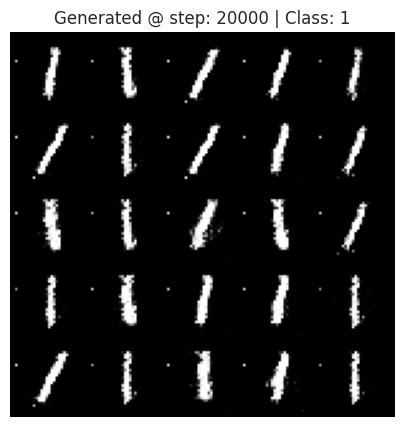

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
21000 gen_loss: 2.2377, disc_loss: 0.2911


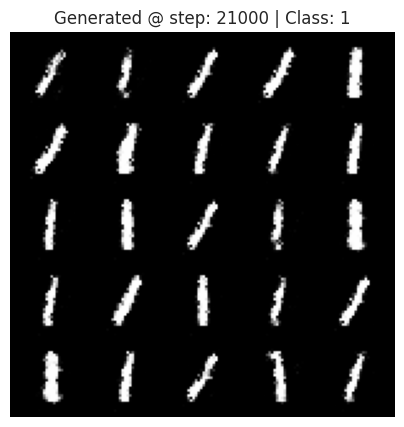

22000 gen_loss: 2.0159, disc_loss: 0.3077


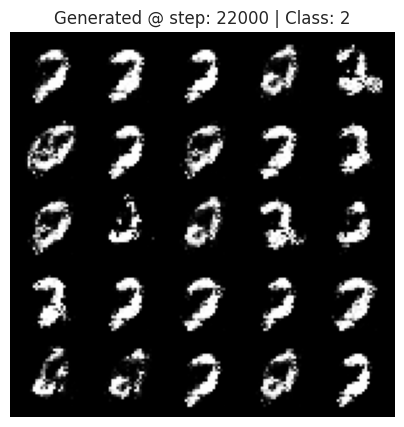

23000 gen_loss: 2.0875, disc_loss: 0.3630


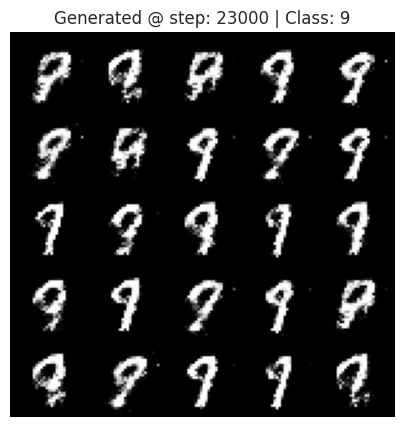

24000 gen_loss: 2.1643, disc_loss: 0.2487


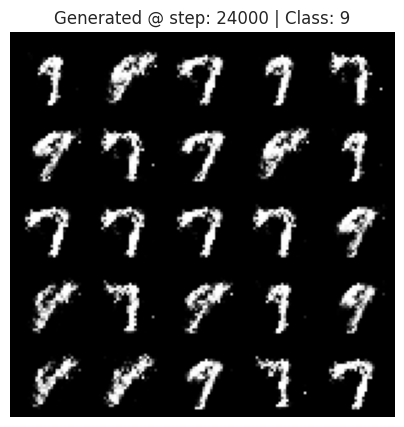

25000 gen_loss: 1.8864, disc_loss: 0.3121


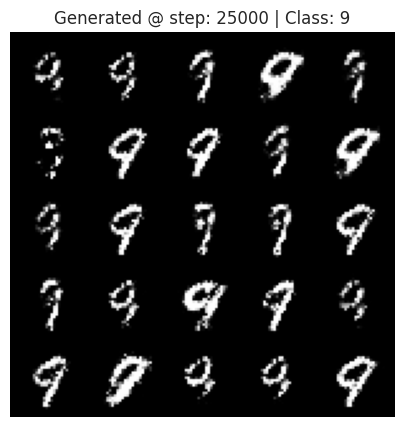

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
26000 gen_loss: 1.7122, disc_loss: 0.3487


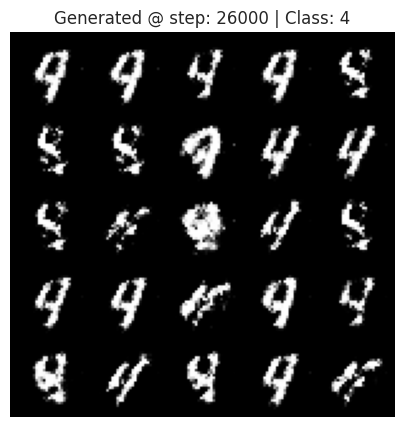

27000 gen_loss: 1.9326, disc_loss: 0.3571


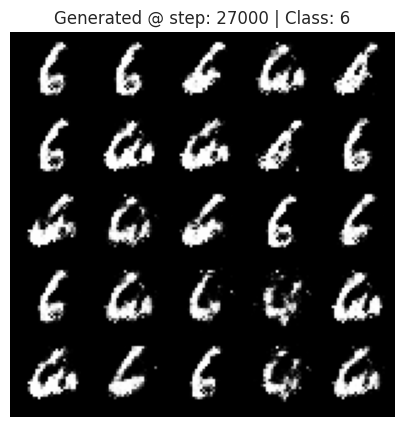

28000 gen_loss: 1.6331, disc_loss: 0.3837


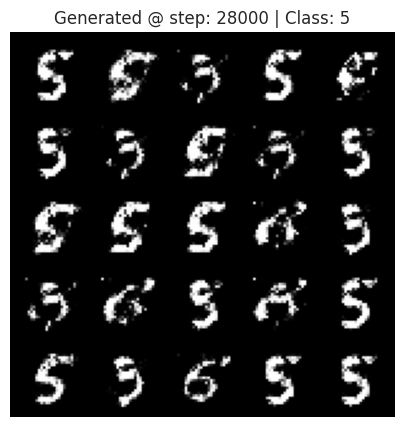

29000 gen_loss: 1.8008, disc_loss: 0.3656


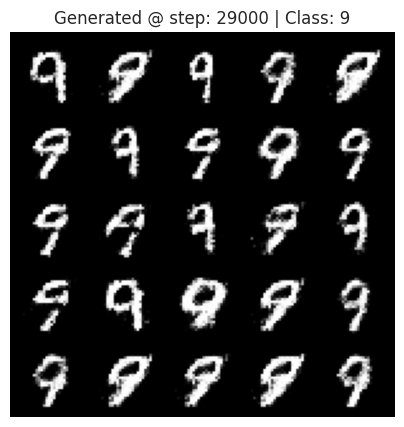

30000 gen_loss: 1.4182, disc_loss: 0.3721


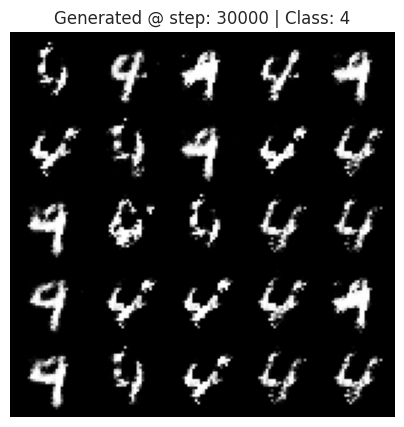

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
31000 gen_loss: 1.6856, disc_loss: 0.3343


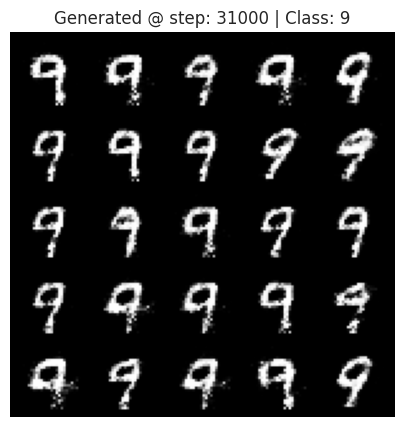

32000 gen_loss: 1.7794, disc_loss: 0.4263


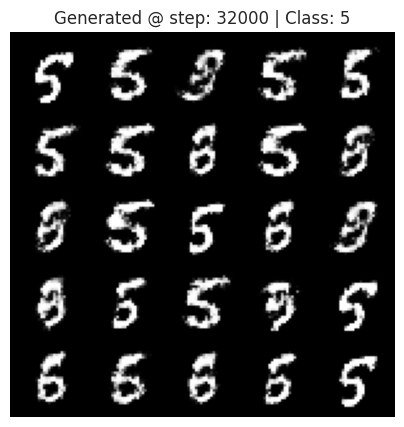

33000 gen_loss: 1.7509, disc_loss: 0.3339


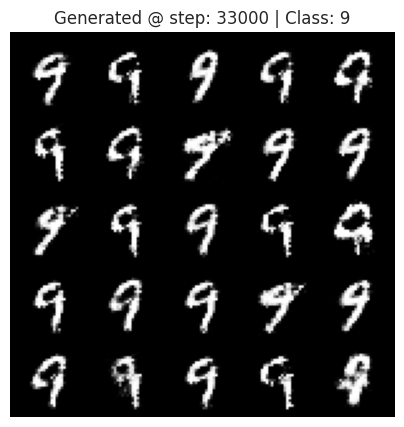

34000 gen_loss: 1.7905, disc_loss: 0.3354


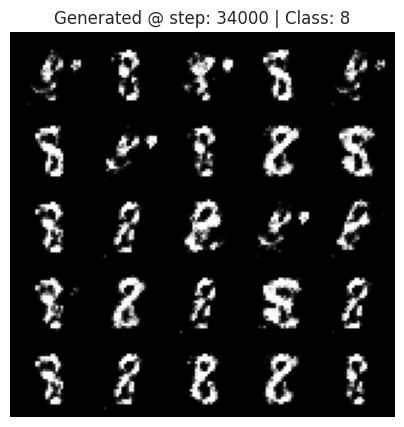

35000 gen_loss: 1.4969, disc_loss: 0.4076


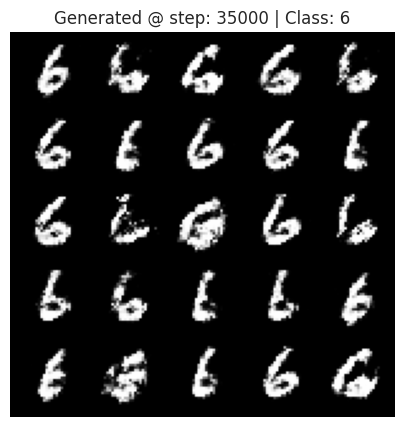

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
36000 gen_loss: 1.8144, disc_loss: 0.4109


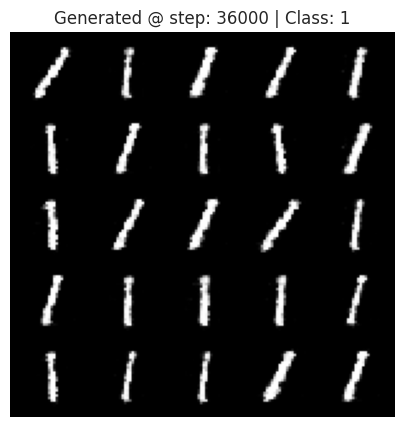

37000 gen_loss: 1.1049, disc_loss: 0.5695


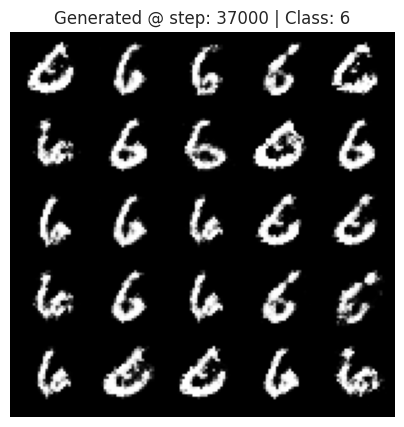

38000 gen_loss: 1.3162, disc_loss: 0.4837


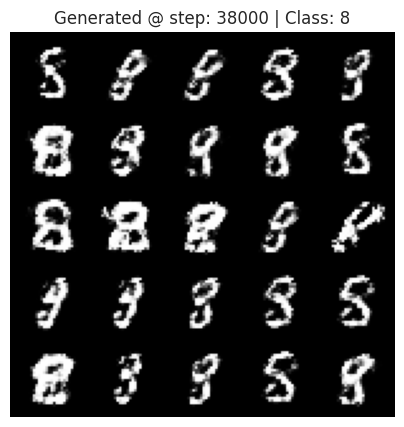

39000 gen_loss: 1.5612, disc_loss: 0.4539


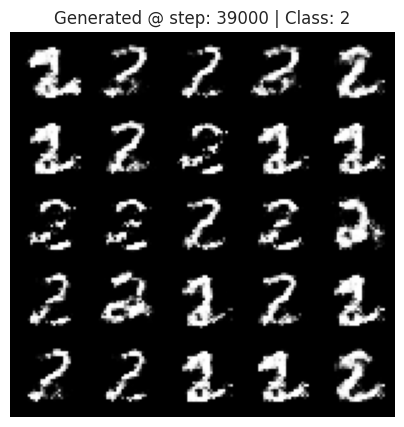

40000 gen_loss: 1.2720, disc_loss: 0.4247


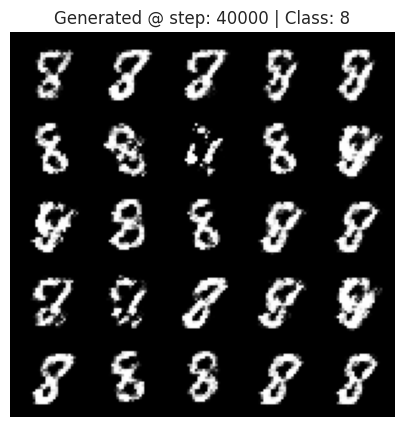

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
41000 gen_loss: 1.3000, disc_loss: 0.4411


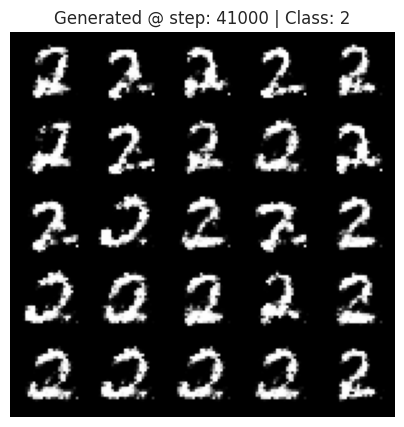

42000 gen_loss: 1.4578, disc_loss: 0.4259


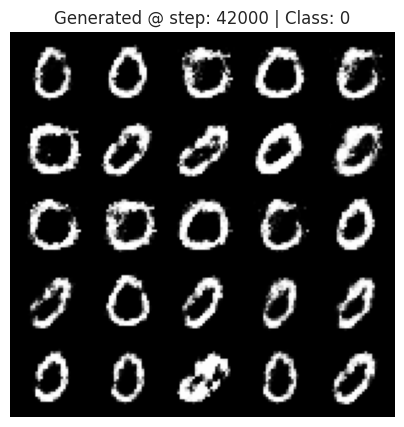

43000 gen_loss: 1.2893, disc_loss: 0.4008


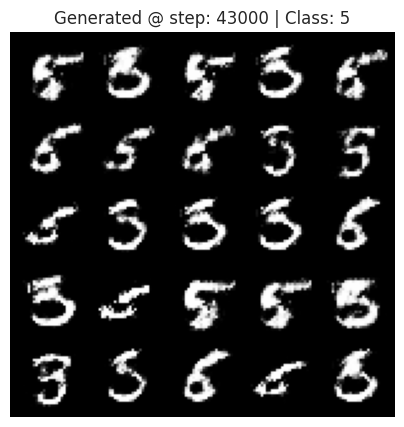

44000 gen_loss: 1.3036, disc_loss: 0.5195


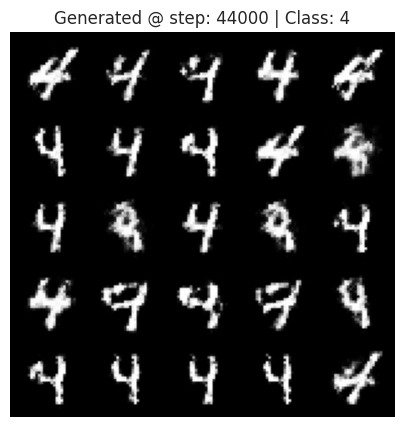

45000 gen_loss: 1.4089, disc_loss: 0.4650


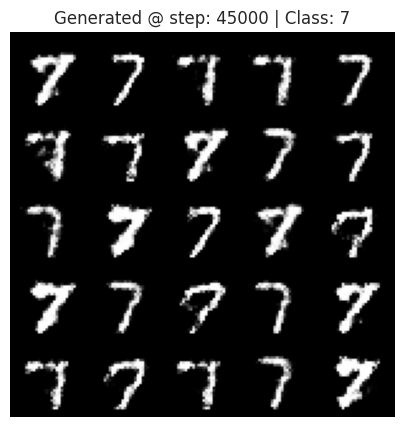

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
46000 gen_loss: 1.3755, disc_loss: 0.5180


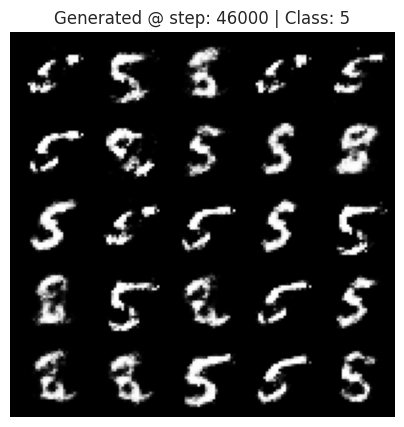

47000 gen_loss: 1.1481, disc_loss: 0.4930


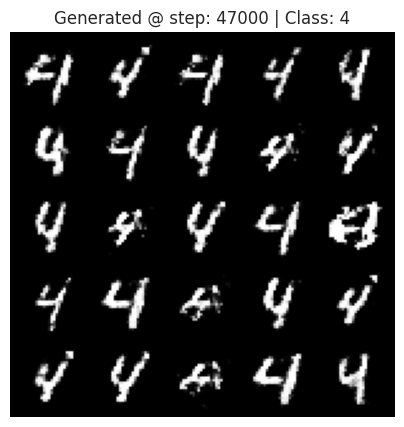

48000 gen_loss: 1.1770, disc_loss: 0.4635


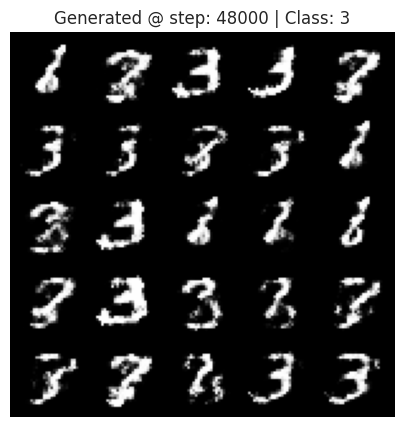

49000 gen_loss: 1.4147, disc_loss: 0.4577


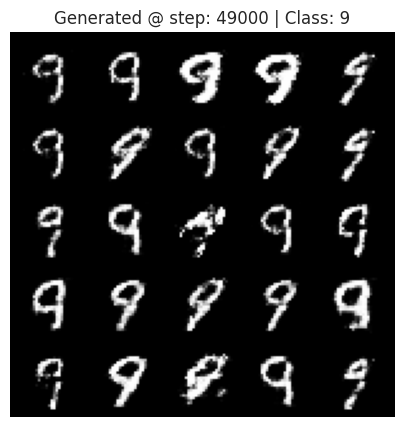

50000 gen_loss: 1.2990, disc_loss: 0.4469


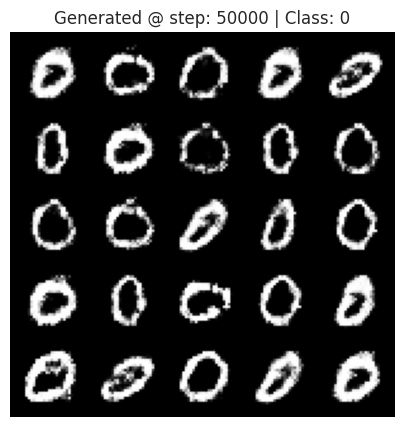

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
51000 gen_loss: 1.4132, disc_loss: 0.4317


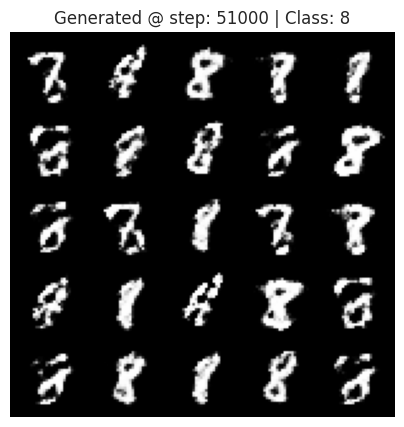

52000 gen_loss: 1.2328, disc_loss: 0.5092


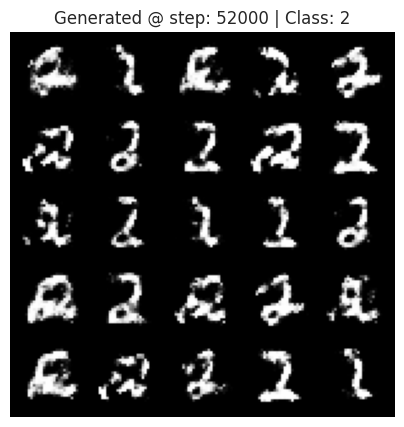

53000 gen_loss: 1.3024, disc_loss: 0.5289


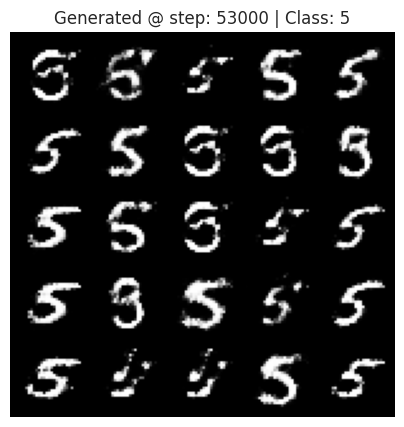

54000 gen_loss: 1.3121, disc_loss: 0.4968


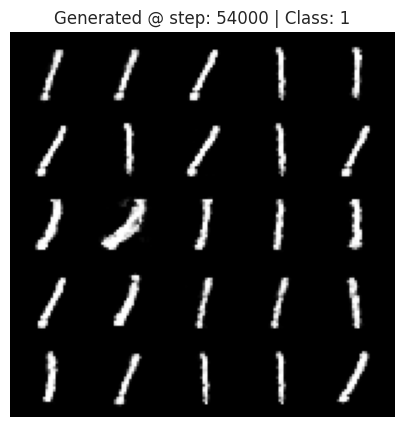

55000 gen_loss: 1.1932, disc_loss: 0.5176


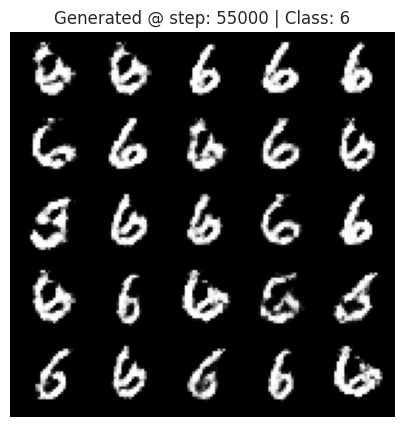

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
56000 gen_loss: 1.3477, disc_loss: 0.4318


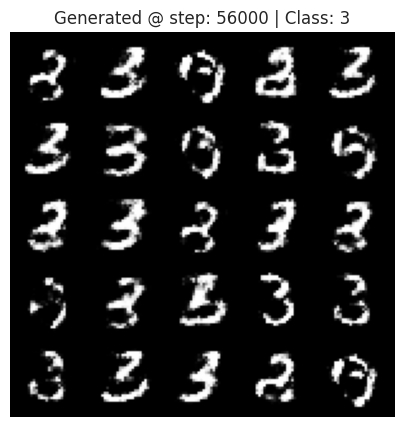

57000 gen_loss: 1.1470, disc_loss: 0.5453


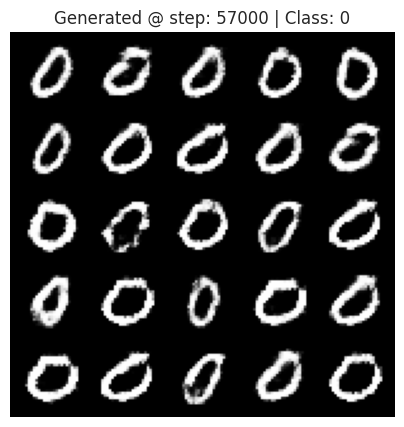

58000 gen_loss: 1.1843, disc_loss: 0.4794


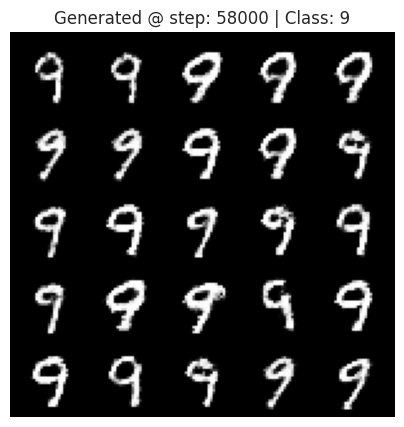

59000 gen_loss: 1.2379, disc_loss: 0.5583


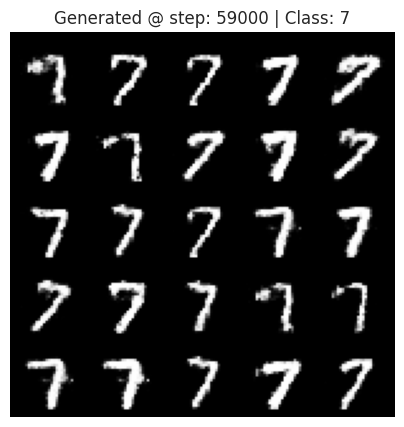

60000 gen_loss: 1.3820, disc_loss: 0.4801


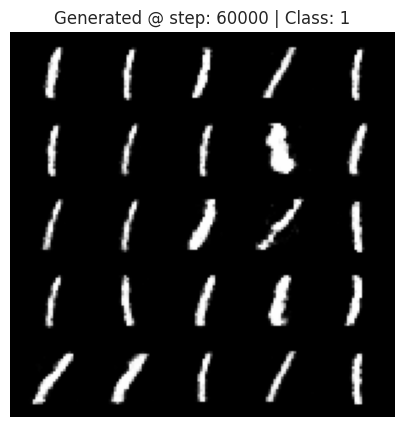

generator.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

>> Uploaded generator.pt to Gholamreza/conditional_gan_mnist/generator.pt


discriminator.pt:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

>> Uploaded discriminator.pt to Gholamreza/conditional_gan_mnist/discriminator.pt
61000 gen_loss: 1.1916, disc_loss: 0.4892


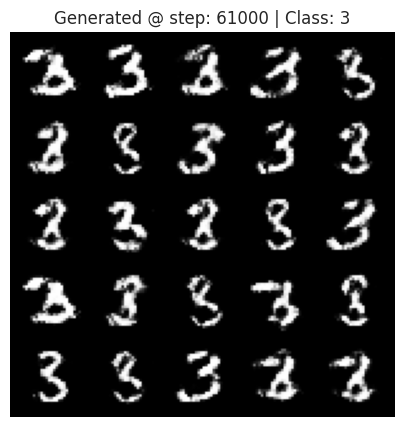

62000 gen_loss: 1.4283, disc_loss: 0.4962


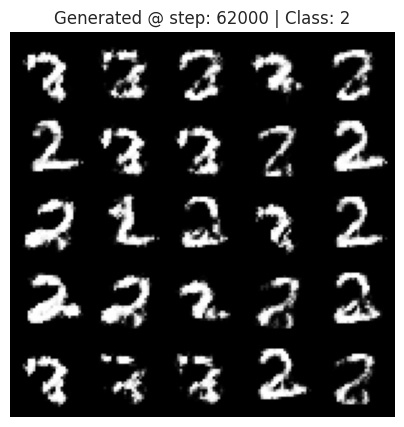

63000 gen_loss: 1.2436, disc_loss: 0.4820


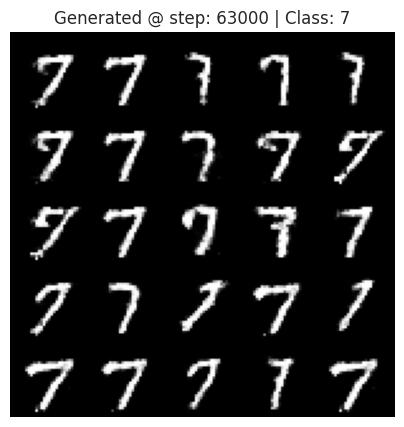

KeyboardInterrupt: 

In [25]:
train(generator, discriminator, nn.BCEWithLogitsLoss(), images, 64, 10, device, alpha=0.5)

## Losses Plot

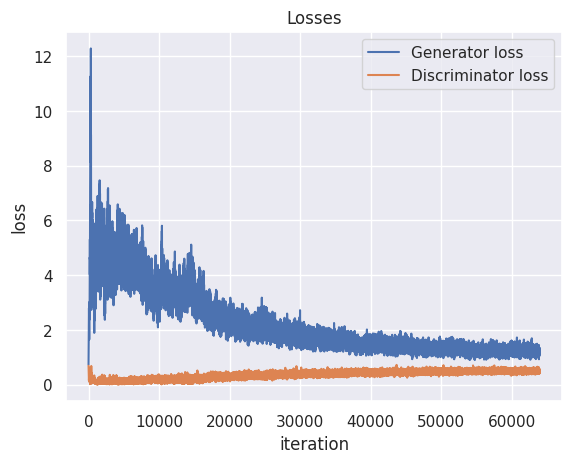

In [26]:
# plot the losses
plt.title("Losses")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.plot(gen_losses, label="Generator loss")
plt.plot(disc_losses, label="Discriminator loss")
plt.legend()
plt.show()

## Inference Test

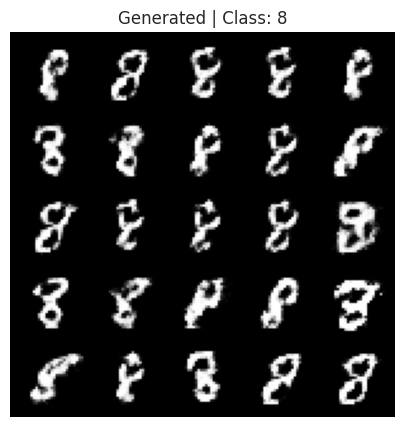

In [29]:
generator.eval()
label = 8
fake_eval_batch = generator(get_noise(25, 10, device=device), torch.tensor([label] * 25).to(device))
display_image_grid(fake_eval_batch, title=f"Generated | Class: {label}")

In [49]:
def check_generation(generator):
    generator.eval()
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9] * 10).to(device)
    fake_eval_batch = generator(get_noise(100, 10, device=device), labels).view(-1, 1, 28, 28)
    grid = make_grid(fake_eval_batch.detach().cpu(), nrow=10).permute(1, 2, 0).numpy()
    plt.figure(figsize=(9, 9))
    plt.title("Generated Images")
    plt.axis('off')
    plt.xlabel("Class")
    plt.imshow(grid)
    plt.show()

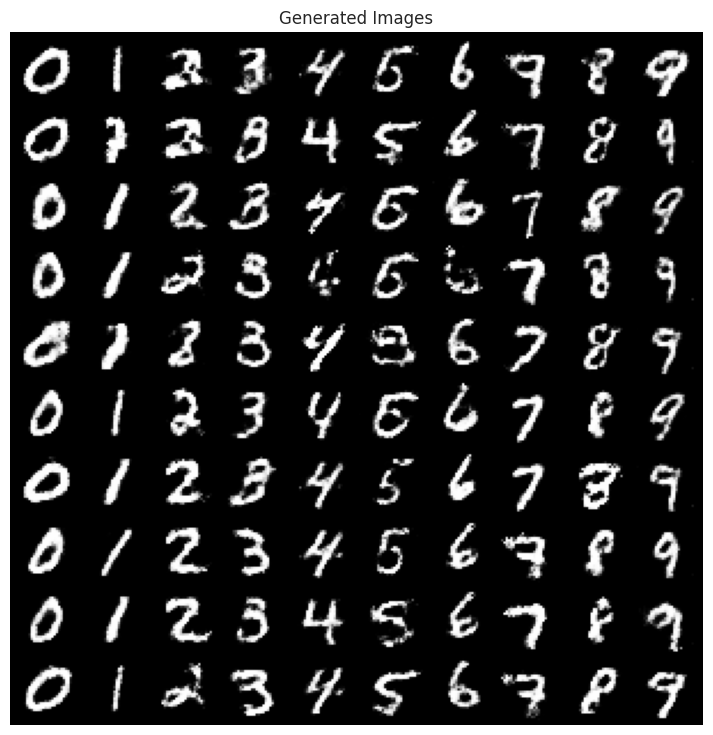

In [50]:
check_generation(generator)

In [53]:
def generate_digit(generator, digit):
    generator.eval()
    labels = torch.tensor([digit] * 25).to(device)
    fake_eval_batch = generator(get_noise(25, 10, device=device), labels).view(-1, 1, 28, 28)
    grid = make_grid(fake_eval_batch.detach().cpu(), nrow=5).permute(1, 2, 0).numpy()
    plt.figure(figsize=(5, 5))
    plt.title(f"Generated Images for digit: {digit}")
    plt.axis('off')
    plt.xlabel("Class")
    plt.imshow(grid)
    plt.show()

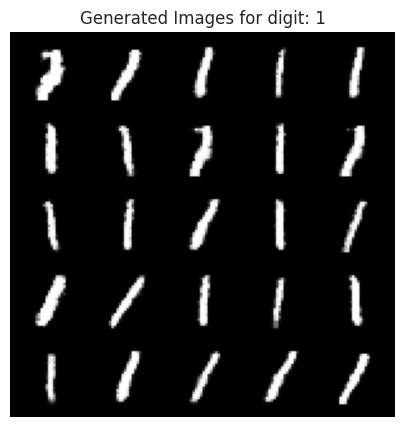

In [58]:
generate_digit(generator, 1)